# Implementação - Modelos de Volatilidade Estocástica

**Aluno:** Franklin Oliveira

-----

Nesse notebook, vamos apresentar a implementação de modelos de volatilidade estocástica (SV). Para isso, vamos adotar a formulação de modelos de espaço-estado, onde estamos interessados em estimar a volatilidade (estado - $h_t$), que não é diretamente observável, para uma série $y_t$ realizada.  

Vamos começar com o modelo mais simples...

-----

## Modelo Canônico

<center> $ y_t = \beta \exp \left\{\frac{h_t}{2} \right\} u_t~~~$ <font color='blue'>(output - medições observadas) </font></center>

<center> $ h_t = \mu + \phi(h_{t-1} - \mu) + \sigma \eta_t  ~~~$ <font color='green'>(mudança de estado) </font></center>

<center> $h_1 \sim \mathcal{N} \left(\mu, \frac{\sigma^2}{1 - \phi^2} \right)$ </center>

Onde $h_t$ é a log-volatilidade não observada de $y_t$, e $u_t$ e $\eta_t$ são ruídos brancos gaussianos, i.e., 

$$u_t \sim \mathcal{N}(\mu_u, \sigma_u^2)~~\text{e}~~\eta_t \sim \mathcal{N}(\mu_{\eta}, \sigma_{\eta}^2)$$


Para exemplificar, vamos usar esse modelo para estimar a volatilidade do índice Ibovespa.



In [1]:
%matplotlib inline

import numpy as np
import numpy.random as rng
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.stats import multivariate_normal, invgamma
from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible
from statsmodels.graphics.tsaplots import plot_acf

sns.set()

from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Importando dados do Ibovespa

Text(0, 0.5, 'mil pontos')

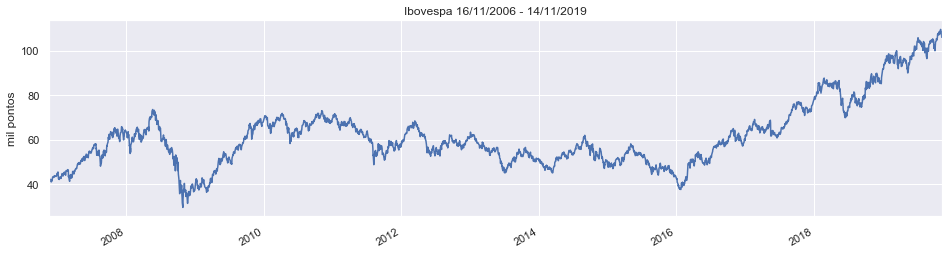

In [2]:
# Importando a série do Ibovespa
df = pd.read_csv('ibov.csv', sep=';', encoding='utf-8-sig', index_col=0)

# data para datetime
df['Data/Hora'] = pd.to_datetime(df['Data/Hora'], format='%d/%m/%Y')

plt.tight_layout()
df.set_index('Data/Hora')['Cotação'].plot(kind='line', figsize=(16,4), 
                                          title='Ibovespa 16/11/2006 - 14/11/2019')
plt.xlabel('')
plt.ylabel('mil pontos')

... Tomando o log dos retornos diários...

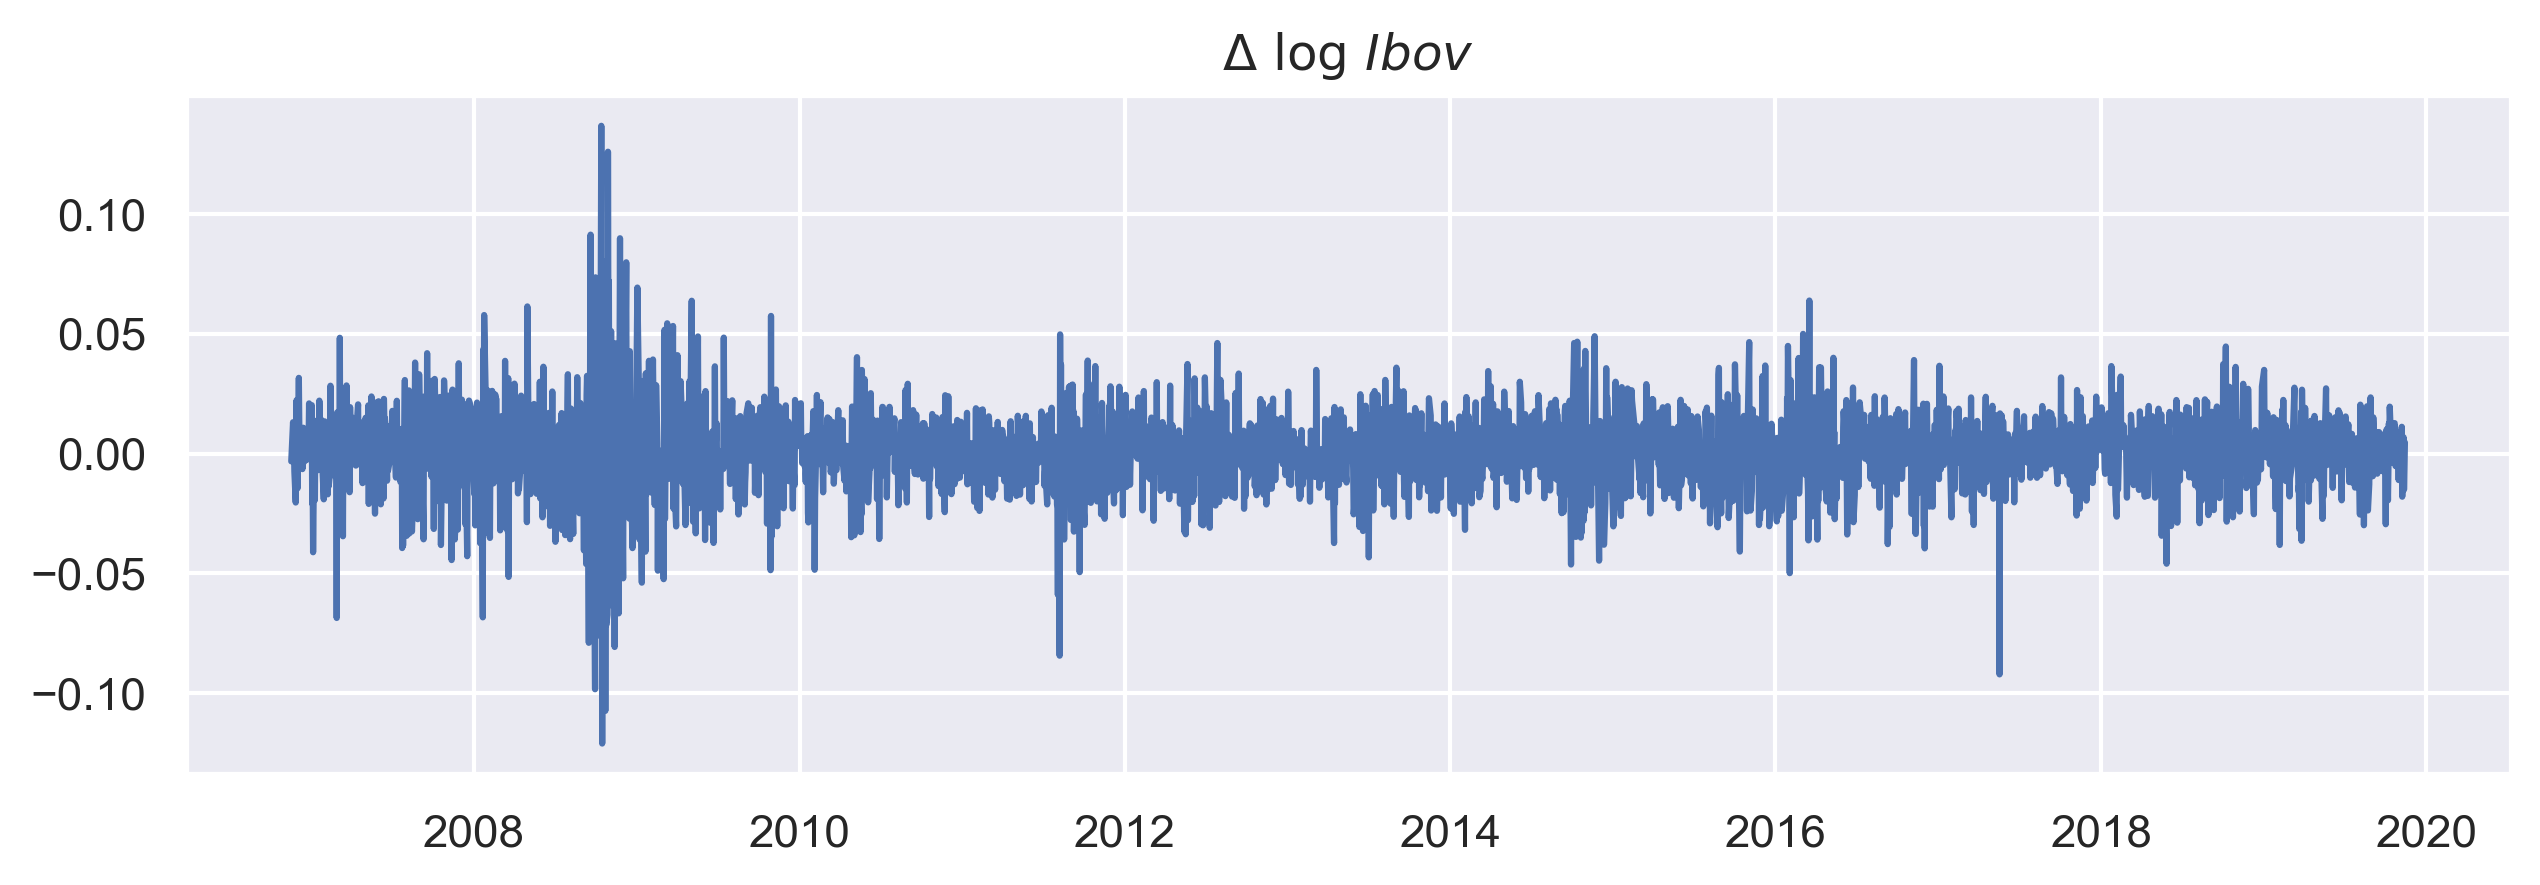

In [3]:
ibov = df.set_index('Data/Hora')['Cotação'].sort_index(ascending=True)
log_ibov = np.log(ibov).diff()[1:] 

fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
ax.plot(log_ibov, label=r'$\delta \log Ibov$')
ax.set_title(r'$\Delta ~\log ~Ibov$')
ax.yaxis.grid(b=True);

plt.savefig('log_ret_ibov.png')

**... E, agora, definindo y...** (OBS: serão utilizadas 1500 observações para simulação)

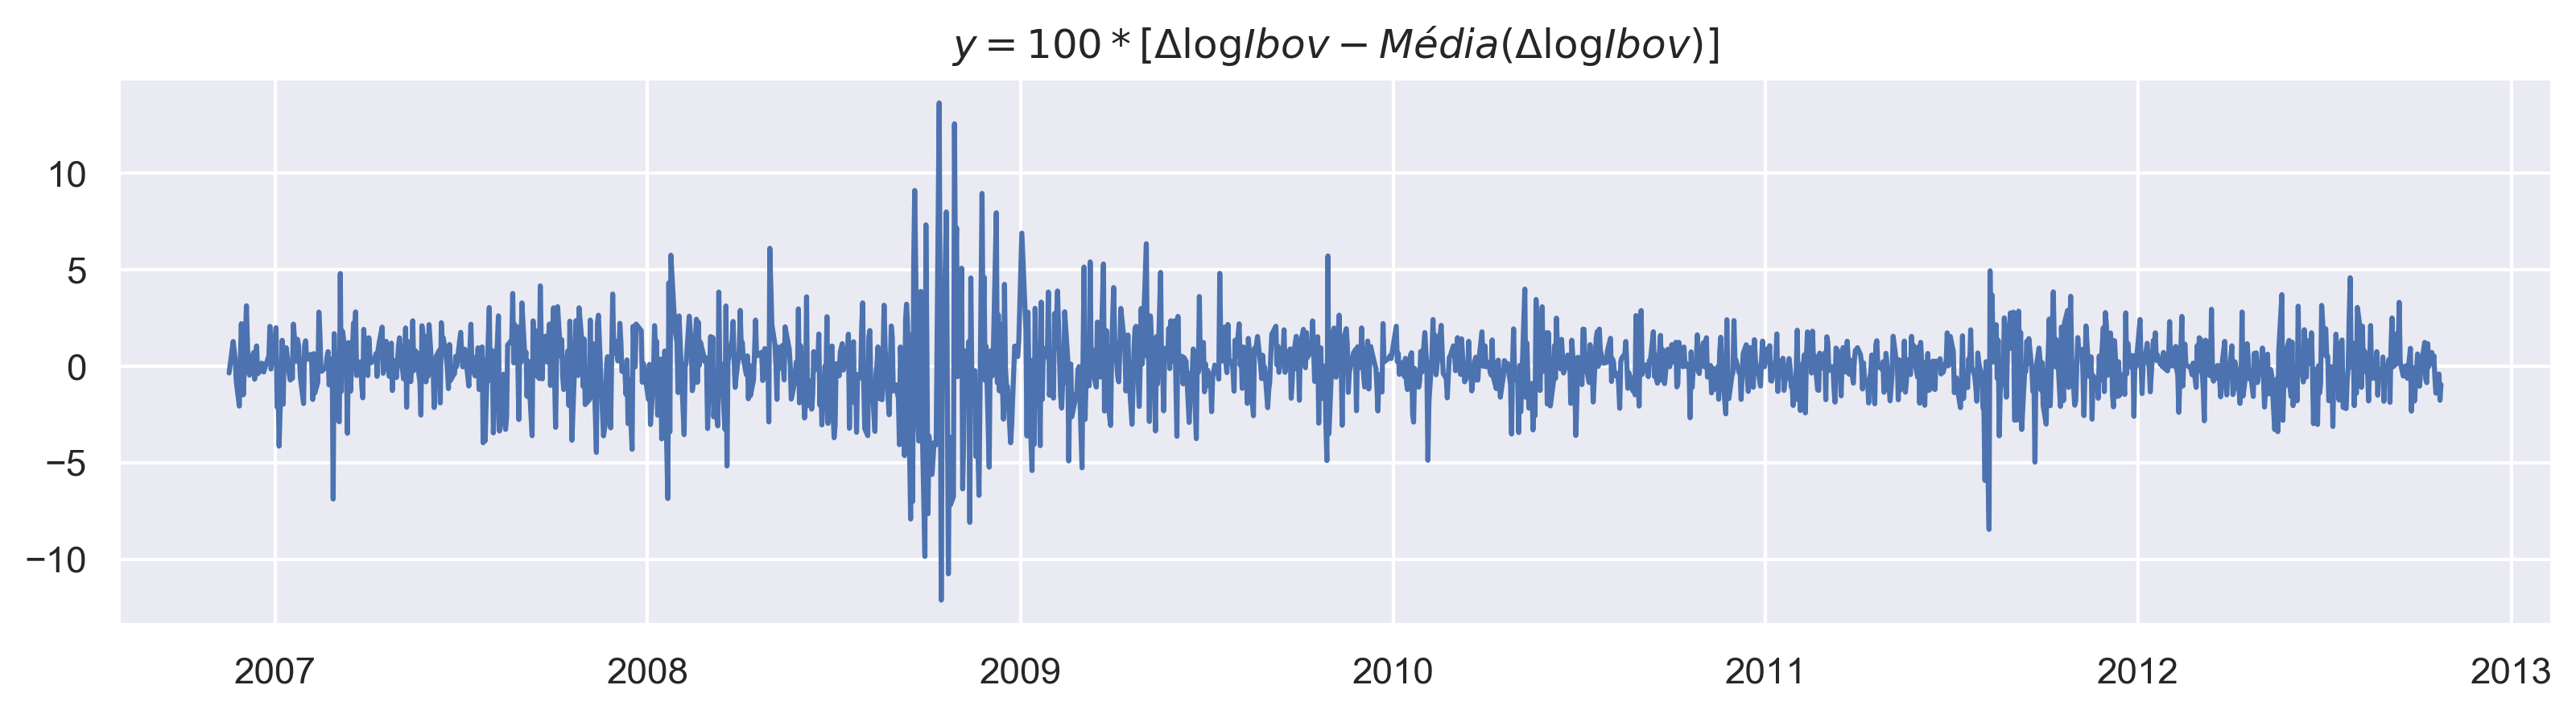

In [4]:
# y = log-retorno corrigido pela média
y = 100*(log_ibov - np.mean(log_ibov))[:1500]

fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(y, label=r'$\Delta \log Ibov$')
ax.set_title(r'$y = 100*[\Delta \log Ibov - Média(\Delta \log Ibov)]$')
ax.yaxis.grid(b=True);

Uma das premissas do modelo SV é que o $y$ segue uma distribuição Gaussiana...

Na figura abaixo, temos a intuição de que o $y$ é "quase" normal.

Text(0.5, 0, '$y$')

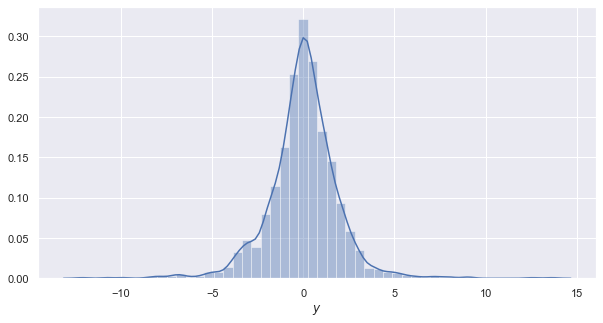

In [5]:
plt.figure(figsize=(10,5))
sns.distplot(y, norm_hist=True)
plt.xlabel(r'$y$')

Fazendo um teste de normalidade simples baseado em D'Agostino e
Pearson (1971 e 1973) - teste que combina assimetria e curtose - temos que o $p-$valor é muito baixo (da ordem de $e^{-45}$). Assim, podemos rejeitar a hipótese nula de que a série $y$ foi amostrada de uma gaussiana.

In [6]:
stats.normaltest(y)

NormaltestResult(statistic=204.172365039829, pvalue=4.6188541960330754e-45)

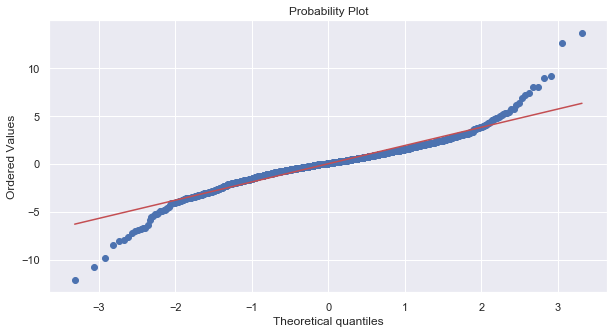

In [7]:
plt.figure(figsize=(10,5))
stats.probplot(y, dist="norm", plot=plt);

No entanto, ainda supondo que $y \sim \mathcal{N}(\cdot, \cdot)$, vamos simular o algoritmo base. 

<br>

## Algoritmo base: Gibbs-Sampler


### Passo a passo:

> 1. Inicializar $h$ e $\theta = (\phi,\mu,\sigma^2_{\eta})$
> 2. Amostrar $h_t$ de $h_t \mid h_{\t}, y, \theta, t=1, \dots, n.$
> 3. Amostrar $\sigma^2_{\eta}$ de $\sigma^2_{\eta} \mid y, h, \phi, \mu, \beta$
> 4. Amostrat $\phi$ de $\phi \mid h, \mu, \beta, \sigma^2_{\eta}$
> 5. Amostrar $\mu$ de $\mu \mid h, \phi, \sigma^2_{\eta}$
> 6. Voltar para o passo 2.

No paper original (Kim, Shephard e Chib - 1998), foram executadas 1.000.000 iterações, com um *burn-in* de 50.000 observações. Nesse notebook, para fins de ilustração, serão executadas 300 mil iterações, com um *burn-in* de 10 mil observações. (OBS: adicionalmente, serão armazenadas uma observação a cada 10 iterações - para não sobrecarregar os *plots*)

**- Notação**:

> $N = $ Número de iterações; <br>
> $T = $ Número de observações (Tamanho da série temporal)

### Prioris

#### Priori conjugada para $\sigma^2_{\eta}$:

$$\sigma_\eta^2 | \phi, \mu \sim IG(\sigma_r / s, S_\sigma / 2)$$

Onde $\sigma_r = 5$ e $S_\sigma = 0.01 \times \sigma_r = 0.05$.

#### Priori de $\phi$:

$$\phi^* \sim Beta(\phi^{(1)}, \phi^{(2)})$$

Onde $\phi^* = (\phi + 1) / 2$, $\phi^{(1)} = 20$ e $\phi^{(2)} = 1.5$. Isto é, 

$$\pi(\phi) \propto \left [ \frac{(1 + \phi)}{2} \right ]^{\phi^{(1)} - 1} \left [ \frac{(1 - \phi)}{2} \right ]^{\phi^{(2)} - 1} $$


#### Priori de $\mu$:

$$\mu \sim N(0, 10)$$

<br>

### Criando funções auxiliares para amostrar das posterioris condicionais.


#### Amostrando de $\sigma^2_n \mid y, h,\phi, \mu \sim IG \left ( \frac{n + \sigma_r}{2},
\frac{S_\sigma + (h_1 - \mu)^2(1 - \phi^2) + \sum_{i=1}^{n-1} [(h_{t+1} - \mu) - \phi(h_t-\mu)]^2}{2} \right )$

In [8]:
def posterior_sigma2(T, states, phi, mu, param_priori=(5, 0.05)):
    sigma_r = param_priori[0] 
    S_sigma = param_priori[1]

    v1 = sigma_r + T
    termo1 = (states[0] - mu)**2 * (1 - phi**2)
    somatorio = np.sum(((states[1:] - mu) - phi * (states[:-1] - mu))**2)
    delta1 = S_sigma + termo1 + somatorio

    return invgamma.rvs(v1/2, scale=delta1/2)

#### Amostrando de $\phi \mid h, \mu, \beta, \sigma^2_{\eta}$.

    Algoritmo de Metropolis: 

> 1. Propomos um valor $\phi^*$ de $N(\hat \phi, V_\theta)$, onde
>
>     $\hat \phi =\sum_{t=1}^{n-1}(h_{t+1}-\mu)(h_t - \mu)/\sum_{t=1}^{n-1}(h_t - \mu)^2$
>
>     e
>
>     $V_{\phi} = \sigma^2_{\eta} \left \{ \sum_{t=1}^{n-1}(h_t - \mu)^2 \right \}^{-1}$ <br>
> <br>
> 2. Aceitamos $\phi^*$ com probabilidade $\exp\left\{g(\phi^*) - g(\phi^{(i-1)})\right\}$, onde
> 
>     $g(\phi) = \log \pi(\phi) - \frac{(h_1 - \mu)^2 (1 - \phi^2)}{2 \sigma_\eta^2} + \frac{1}{2} \log (1 - \phi^2)$

In [9]:
def g(phi, states, mu, sigma2, param_priori=(20, 1.5)):
    phi_1 = param_priori[0]
    phi_2 = param_priori[1]
    
    # caso o processo seja não estacionário
    if np.abs(phi) >= 1:
        return -np.inf

    priori = ((1 + phi) / 2)**(phi_1 - 1) * ((1 - phi) / 2)**(phi_2 - 1)

    termo1 = (states[0] - mu)**2 * (1 - phi**2) / 2 * sigma2
    termo2 = 0.5 * np.log(1 - phi**2)

    return np.log(priori) - termo1 + termo2

def posterior_phi(states, phi, mu, sigma2, param_priori=(20, 1.5)):
    tmp1 = np.sum((states[1:] - mu) * (states[:-1] - mu))
    tmp2 = np.sum((states[:-1] - mu)**2)
    phi_hat = tmp1 / tmp2
    V_phi = sigma2 / tmp2

    phi_prop = norm.rvs(phi_hat, scale=V_phi**0.5)
    g_prop = g(phi_prop, states, mu, sigma2, param_priori)
    g_prev = g(phi, states, mu, sigma2, param_priori)
    acc = np.exp(g_prop - g_prev)
    
    if np.random.uniform() < acc:
        return phi_prop
    else:
        return phi 

#### Amostrar de $\mu \mid h, \phi, \sigma^2_{\eta}$:

$$\mu | y, h, \phi, \sigma_\eta^2 \sim N (\hat \mu, \sigma_\mu^2)$$

Onde
$$
\begin{aligned}
\hat \mu & = \sigma_\mu^2 \left [ \frac{(1 - \phi^2)}{\sigma_\eta^2} h_1 + \frac{(1 - \phi)}{\sigma_\eta^2} \sum_{t=1}^{n-1} (h_{t+1} - \phi h_t) \right ] \\
\sigma_\mu^2 & = \sigma_\eta^2 \left [ (n - 1)(1 - \phi)^2 + (1 - \phi^2) \right ]^{-1}
\end{aligned}
$$

In [10]:
def posterior_mu(T, states, phi, sigma2):
    sigma2_mu = sigma2 / ((T - 1) * (1 - phi)**2 + (1 - phi**2))

    termo1 = ((1 - phi**2) / sigma2) * states[0]
    termo2 = ((1 - phi) / sigma2) * np.sum(states[1:] - phi * states[:-1])
    mu_hat = sigma2_mu * (termo1 + termo2)

    return norm.rvs(loc=mu_hat, scale=sigma2_mu**0.5)

### Inicializando parâmetros

In [31]:
### Passo 1:
T = len(y) # tamanho da série temporal 
N = 5001  # número de iterações

h = np.zeros(N*T).reshape(N,T)  # matriz de estados
phi = np.zeros(N).reshape(N)    # vetor de phi
s2_n = np.zeros(N).reshape(N)   # vetor de sigma2
mu = np.zeros(N).reshape(N)     # vetor de mu
beta = np.zeros(N).reshape(N)   # vetor de beta

### valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
mu[0] = 0
beta[0] = np.exp(mu[0]/2)

### Executando o algoritmo base

In [32]:
# np.random.seed(205)
for i in tqdm(range(1,N)):
    ### Passo 2: amostrando de h    
    for t in range(1,T-1):
        h_star = mu[i-1] + phi[i-1]*((h[i,t-1]-mu[i-1]) + (h[i,t+1]-mu[i-1]))/(1+phi[i-1]**2)

        v2 = s2_n[i-1]/(1+phi[i-1]**2)
        mu_t = h_star + (v2/2) * (y[t]**2 * np.exp(-h_star)-1)
        
        acc = False
        while not acc:   # OBS: executa o loop até aceitar um valor de h
            h_prop = norm.rvs(loc=mu_t, scale=np.sqrt(v2))   # h proposto

            # probabilidade de aceitação:
            f_star = -0.5*h_prop - (y[t]**2)/2 * np.exp(-h_prop)
            g_star = -0.5*h_prop - (y[t]**2)/2 * (np.exp(-h_star)*(1+h_star) - h_prop*np.exp(-h_star))

            alpha = f_star - g_star
            if  np.log(np.random.uniform()) < alpha:   
                h[i,t] = h_prop
                acc = True

    ### Passo 3: amostrando sigma2
    s2_n[i] = posterior_sigma2(T, h[i], phi[i-1], mu[i-1])
    
    ### Passo 4: amostrando phi
    phi[i] = posterior_phi(h[i], phi[i-1], mu[i-1], s2_n[i])
    
    ### Passo 5: amostrando mu
    mu[i] = posterior_mu(T, h[i], phi[i], s2_n[i])
    beta[i] = np.exp(mu[i]/2)   # atualiza beta

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

<br>

**Retirando burnin e armazenando apenas algumas iterações...**

In [21]:
# burnin e step-size para fazer os plots
burnin = 100
step = 1

In [22]:
phi2 = phi[burnin::step]
mu2 = mu[burnin::step]
beta2 = beta[burnin::step]
s2_n2 = s2_n[burnin::step]

#### Salvando os resultados em csv

OBS: salvei os resultados apenas uma vez, por precaução. Os arquivos do h ocupam aprox. 800Mb.

In [19]:
# pd.DataFrame(h).to_csv('algo_base_h.csv')
# pd.DataFrame([phi, mu, s2_n, beta], index=['phi', 'mu', 's2_n', 'beta']).transpose().to_csv('algo_base_params.csv')

### Gráficos

**Cadeias de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

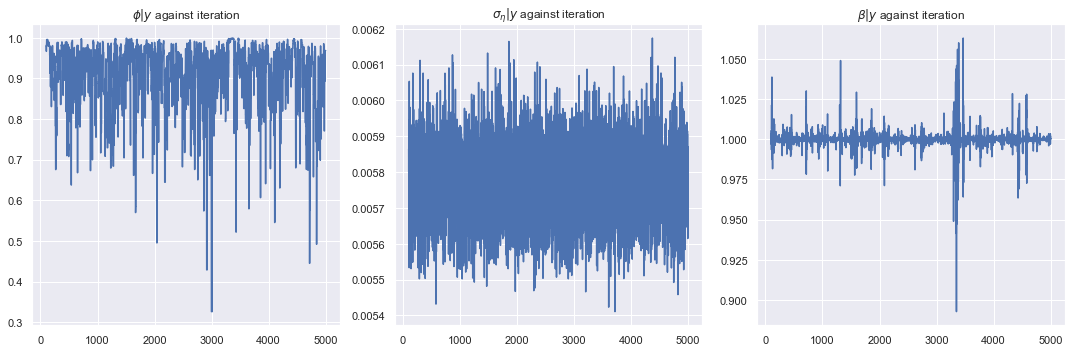

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(burnin,N,step)),y=phi2, ax = ax[0])
sns.lineplot(x=list(range(burnin,N,step)),y=s2_n2**0.5, ax = ax[1])
sns.lineplot(x=list(range(burnin,N,step)),y=beta2, ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

plt.tight_layout()
# plt.savefig('algo_base_chains.png')

**Distribuições de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

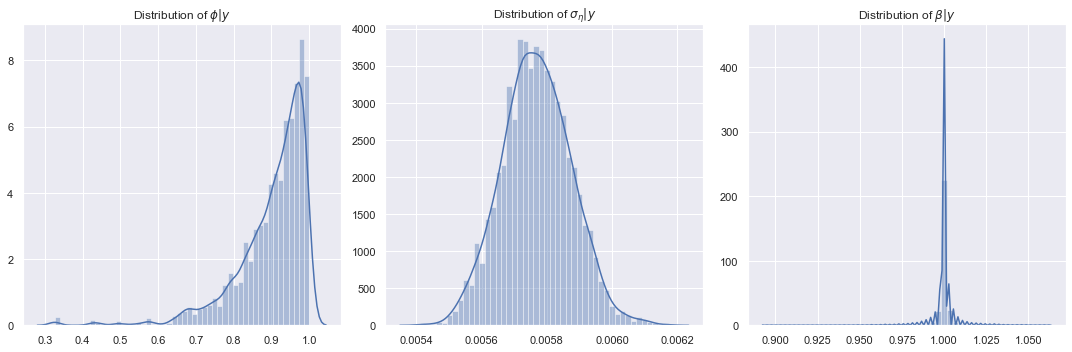

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5));
sns.distplot(phi2, ax = ax[0], norm_hist= True);
sns.distplot(s2_n2**0.5, ax = ax[1], norm_hist= True);
sns.distplot(beta2, ax = ax[2], norm_hist= True);

ax[0].set_title(r'Distribution of $\phi|y$');
ax[1].set_title(r'Distribution of $\sigma_{\eta}|y$');
ax[2].set_title(r'Distribution of $\beta|y$');

plt.tight_layout()
# plt.savefig('algo_base_dist.png')

**Autocorrelação de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

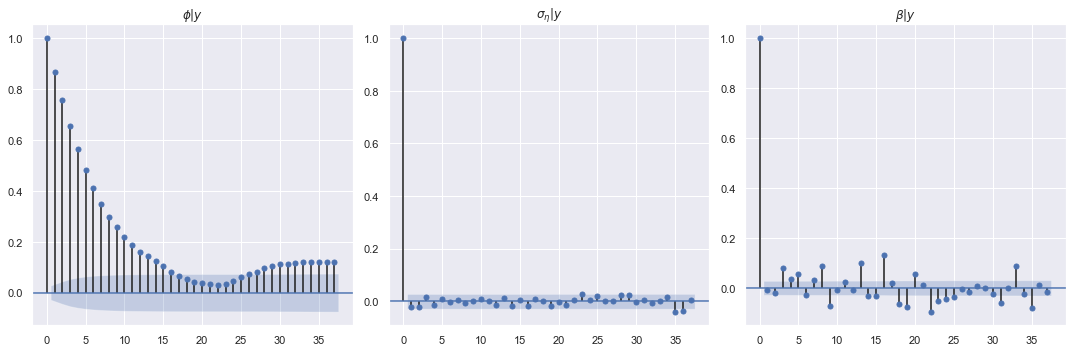

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_acf(phi2, ax = ax[0], title=r'$\phi | y$');
plot_acf(s2_n2**0.5, ax = ax[1], title=r'$\sigma_{\eta} | y$');
plot_acf(beta2, ax = ax[2], title=r'$\beta | y$');

plt.tight_layout()
# plt.savefig('algo_base_autocorr.png')

### Calculando algumas métricas

In [31]:
# média
print(r'- média de phi:',np.mean(phi))
print(r'- média de sigma:',np.mean(s2_n**0.5))
print(r'- média de beta:',np.mean(np.exp(mu/2)))

- média de phi: 0.8888501519226559
- média de sigma: 0.005891730855052417
- média de beta: 1.0000085872067799


In [32]:
# desvio-padrão
print(r'- sd de phi:',np.std(phi))
print(r'- sd de sigma:',np.std(s2_n**0.5))
print(r'- sd de mu:',np.std(np.exp(mu/2)))

- sd de phi: 0.10672101845197103
- sd de sigma: 0.0007094166814055091
- sd de mu: 0.006788106727610407


In [35]:
# Erro-padrão numérico
print('MC S.E. phi:',stats.sem(phi))
print('MC S.E. sigma:',stats.sem(s2_n**0.5))
print('MC S.E. mu:',stats.sem(np.exp(mu/2)))

MC S.E. phi: 0.00030807704365718244
MC S.E. sigma: 2.0479095598854086e-06
MC S.E. mu: 1.9595576232368893e-05


In [36]:
def ineficiencia(chain, Bm):
    acf = sm.tsa.stattools.acf(chain, nlags=Bm)
    inef = 0
    for i in range(Bm):
        z = i/Bm
        if 0<z and z<=0.5:
            k = 1-6*z**2 + 6*z**3
        elif 0.5<z and z <=1:
            k = 2*(1-z)**3
        else:
            k=0
        inef = inef + 2*Bm/(Bm-1)*k*acf[i]
    return 1+inef

In [37]:
print('Ineficiencia para phi:', ineficiencia(phi, 2000))
print('Ineficiencia para sigma2:', ineficiencia(s2_n**0.5, 4000))
print('Ineficiencia para beta:', ineficiencia(np.exp(mu/2), 2000))

/home/franklin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Ineficiencia para phi: 299.340736728199
Ineficiencia para sigma2: 1653.4609035041651
Ineficiencia para beta: 0.8897990205086249


<br>

## Algoritmo 1: Gibbs-Sampler modificado

Há melhores formas de aproximar a distribuição do termo $\log \varepsilon_t^2$, e de $y$, que não por uma gaussiana. A proposta dos autores com esse algoritmo é aproximar essa distribuição (complicada) por uma mistura de gaussianas, mais precisamente, 7 gaussianas. 

### Forma analítica do modelo

Primeiramente, defina: 
$$
y^*_t = log(y_t^2 + c),~~\text{onde}~c=0.001
$$

Essa transformação em $y_t$ tem como base Fuller (1996) para "robustificar" o estimador QML do modelo de SV para valores muito pequenos de $y_t^2$. Não obstante, note que $y_t$ e $y_t^*$ contém a mesma informação. 

Assim, temos as seguintes equações da dinâmica do modelo:

<br>

<center> $ y^*_t = h_t + z_t $ <font color='blue'>(output - medições observadas) </font></center>

<center> $ h_t = \mu + \phi(h_{t-1} - \mu) + \sigma \eta_t  ~~~$ <font color='green'>(mudança de estado) </font></center>
<center> $f(z_t) = \sum_{i=1}^K q_i f_N(z_t \mid m_t - 1.2704, v_i^2)  ~~~~~~~~~~~~~~$ </center>

<br>

A última equação equivale a 

$$
z_t \mid s_t = 1 \sim \mathcal{N}(m_i - 1.2704, v_i^2),\\
P(s_t = i) = q_i
$$


Os parâmetros das distribuições gaussianas dessa mistura e o vetor de probabilidades de $s$ são exibidos na tabela abaixo:


|    $s$             |      $q_i$      | $m_i$ | $\sigma^2_i$ |
| :-------------:    | :-------------: |:-----:|:-----:|
| 1      | 0.00730   | -10.12999       | 5.79596 |
| 2      | 0.10556   |  -3.97281       | 2.61369 |
| 3      | 0.00002   |   -8.56686      | 5.17950 |
| 4      | 0.04395   |   2.77786       | 0.16735 |
| 5      | 0.34001   |   0.61942       | 0.64009 |
| 6      | 0.24566   |   1.79518       | 0.34023 |
| 7      | 0.25750   |  -1.08819       | 1.26261 |



In [12]:
### parâmetros da mistura de normais
qi = np.array([0.00730, 0.10556, 0.00002, 0.04395, 0.34001, 0.24566, 0.25750])      # probabilidades
mi = np.array([-10.12999, -3.97281, -8.56686, 2.77786, 0.61942, 1.79518, -1.08819]) # médias
vi = np.array([5.79596, 2.61369, 5.17950, 0.16735, 0.64009, 0.34023, 1.26261])      # variâncias

params_mix = np.array([qi, mi, vi]).T

s = np.random.choice(np.array(range(7), dtype=int), size=1, p=qi)[0]                # seletor da mistura

In [13]:
def mistura_gaussiana(J=1, size=1000, mu=0, sigma_2=1, p=[1]):
    '''
    Amostra de uma mistura de gaussianas.
    
    Argumentos:
        - J (int): número de gaussianas na mistura
        - size (int): número de pontos para amostrar
        - mu (list): vetor de médias (de tamanho J)
        - sigma_2 (list): vetor de variâncias (de tamanho J)
        - p (list): vetor de probabilidades 
    
    Output:
        - x (list): vetor de amostragens da mistura
        - z (list): variável categórica
    '''
    # variável categórica
    z = np.random.choice(list(range(J)), size, replace = True, p = p)

    # amostrando k elementos de uma normal com média m[k] e variancia s[k]
    x = []
    for i in range(J):
        ind = len(z[z == i])
        x.extend(rng.normal(mu[i], sigma_2[i], size=ind))
    return x,z

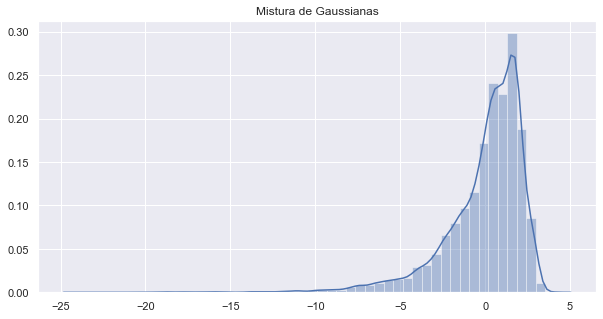

In [14]:
plt.figure(figsize=(10,5))
plt.tight_layout()
sns.distplot(mistura_gaussiana(7, 10000, mi, vi,p=qi)[0], norm_hist=True)

plt.title('Mistura de Gaussianas');

### Passo a Passo:

> 1. Inicializar $s$, $\phi$, $\sigma^2_{\eta}$ e $\mu$.
> 2. Amostrar $h$ de $h \mid y^*, s, \phi, \sigma^2_{\eta}, \mu$
> 3. Amostrar $s$ de $s \mid y^*, h$.
> 4. Atualizar $\phi$, $\sigma^2_{\eta}$ e $\mu$ segundo os passos 3, 4 e 5 do algoritmo base.
> 5. Voltar para o passo 2. 

Antes de prosseguir, vamos definir $y^*$...

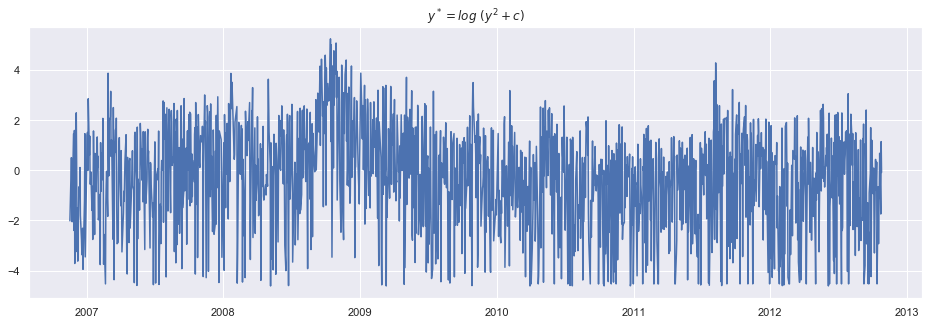

In [15]:
c = 0.01
y_star = np.log(y**2+c)  # definindo y*

plt.figure(figsize=(16,5))
plt.tight_layout()
plt.plot(y_star)
plt.title(r'$y^* = log~(y^2 + c)$');

### Definindo funções auxiliares para a mistura

In [16]:
def mixing_posterior(y, states):
    resid = y - states

    medias = params_mix[:,1] - 1.27036  # médias
    var = params_mix[:,2]              # variâncias
    priori_prob = params_mix[:,0]      # probabilidades
    
    # Make dimensions compatible for broadcasting
    resid = np.repeat(resid[:, None], len(var), axis=-1)
    var = np.repeat(var[None, :], len(y), axis=0)
    priori_prob = np.repeat(priori_prob[None, :], len(y),
                                    axis=0)
    
    # logVerossimilhança...
    loglikelihoods = -0.5 * ((resid - medias)**2 / var +
                             np.log(2 * np.pi * var))
    posteriori = loglikelihoods + np.log(priori_prob)

    # Normalize to get the actual posterior probabilities
    tmp = logsumexp(posteriori, axis=1)
    posteriori_prob = np.exp(posteriori - tmp[:, None])

    return posteriori_prob

def atualiza_mistura(y, states):
    posterior_prob = mixing_posterior(y, states)

    # Amostra s de s|mu, phi, sigma2, y,...
    tmp = np.cumsum(posterior_prob, axis=1) > np.random.uniform(size=len(y))[:, None]
    s_prop = np.argmax(tmp, axis=1)

    return s_prop

### Executando o algoritmo 1:

In [17]:
import statsmodels.api as sm
from scipy.special import logsumexp

In [18]:
T = len(y_star)
y = y_star

### Suavizador gaussiano
modelo = sm.tsa.statespace.MLEModel(y_star, k_states=1, k_posdef=1, initialization='stationary')

# definindo parâmetros iniciais do modelo (Beta = 1, variância 1)
modelo['obs_intercept'] = np.zeros((1, T))
modelo['obs_cov'] = np.zeros((1, 1, T))

# matrizes de espaço-estado
modelo['design', 0, 0] = 1
modelo['selection', 0, 0] = 1

# Simulation smoother (segundo a documentação)
modelo.set_smoother_output(0, smoother_state=True)
smooth = modelo.simulation_smoother()

/home/franklin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [19]:
# Simulation parameters
N = 230000
# burnin = 50000
# thin = 1

# Storage for traces
trace_smoothed = np.zeros((N + 1, T))
trace_states = np.zeros((N+1, T))
trace_mixing = np.zeros((N+1, T), int)
trace_mu = np.zeros((N + 1, 1))
trace_phi = np.zeros((N + 1, 1))
trace_sigma2 = np.zeros((N + 1, 1))

# Initial values (p. 367)
trace_mixing[0] = 0
trace_mu[0] = 0
trace_phi[0] = 0.95
trace_sigma2[0] = 0.02

# Iterations
for i in tqdm(range(1, N + 1)):
    # Atualiza os param. do modelo
    modelo['obs_intercept', 0] = params_mix[trace_mixing[i-1], 1] - 1.27036
    modelo['obs_cov', 0, 0] = params_mix[trace_mixing[i-1], 2]
    
    # Passo 2: atualiza h
    modelo['state_intercept', 0, 0] = trace_mu[i-1] * (1 - trace_phi[i-1])
    modelo['transition', 0, 0] = trace_phi[i-1]
    modelo['state_cov', 0, 0] = trace_sigma2[i-1]
    
    smooth.simulate()
    states = smooth.simulated_state
    trace_states[i] = states[0]

    # Passo 3: atualiza s
    trace_mixing[i] = atualiza_mistura(y, states[0])
    
    # Passo 4: Atualiza sigma2
    trace_sigma2[i] = posterior_sigma2(T, states[0], trace_phi[i-1], trace_mu[i-1])
    
    # Passo 5: Atualiza phi
    trace_phi[i] = posterior_phi(states[0], trace_phi[i-1], trace_mu[i-1], trace_sigma2[i])
    
    # Passo 6: Atualiza mu
    trace_mu[i] = posterior_mu(T, states[0], trace_phi[i], trace_sigma2[i])

100%|██████████| 230000/230000 [25:35<00:00, 149.81it/s]


<br>

### Gráficos

In [20]:
# burnin e step-size para fazer os plots
burnin = 30000
step = 5

In [21]:
phi2 = trace_phi[burnin::step][:,0]
mu2 = trace_mu[burnin::step][:,0]
#beta2 = beta[burnin::step]
s2_n2 = trace_sigma2[burnin::step][:,0]

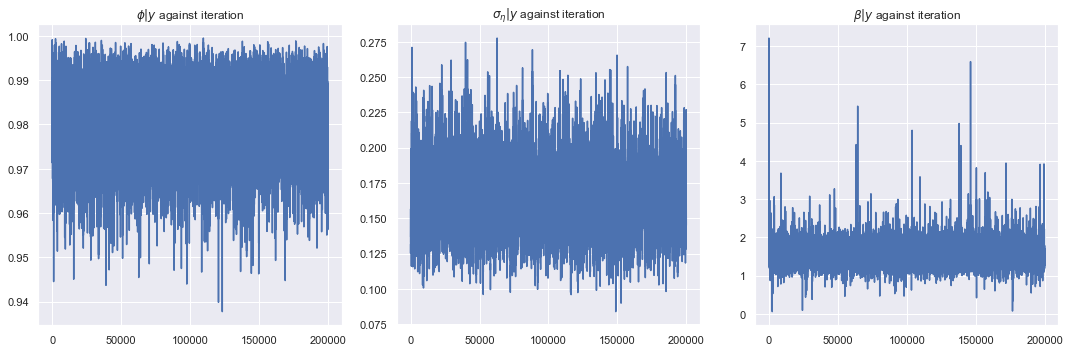

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(0,N+1-burnin,step)),y=phi2, ax = ax[0])
sns.lineplot(x=list(range(0,N+1-burnin,step)),y=s2_n2**0.5, ax = ax[1])
sns.lineplot(x=list(range(0,N+1-burnin,step)),y=np.exp(mu2/2), ax = ax[2])

# mantendo apenas alguns xticks
ax[0].xaxis.set_major_locator(MultipleLocator(50000))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax[1].xaxis.set_major_locator(MultipleLocator(50000))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax[2].xaxis.set_major_locator(MultipleLocator(50000))
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
#ax[0].xaxis.set_minor_locator(MultipleLocator(10))

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

plt.tight_layout()
# plt.savefig('algo1_mistura_chains.png')

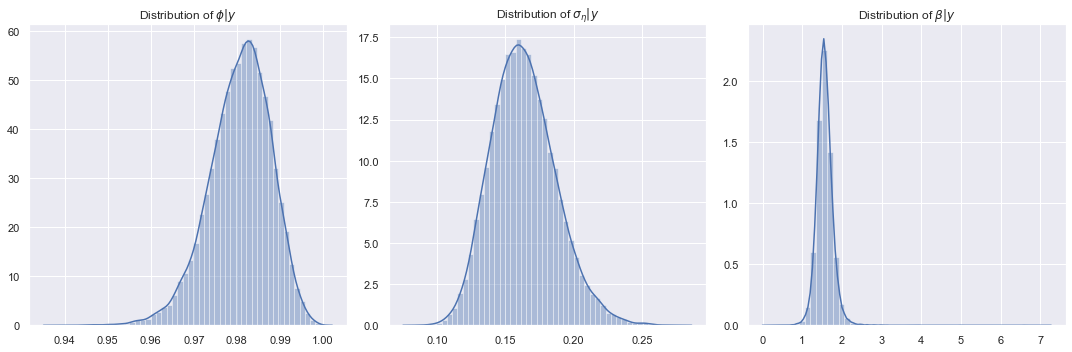

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5));
sns.distplot(phi2, ax = ax[0], norm_hist= True);
sns.distplot(s2_n2**0.5, ax = ax[1], norm_hist= True);
sns.distplot(np.exp(mu2/2), ax = ax[2], norm_hist= True);

ax[0].set_title(r'Distribution of $\phi|y$');
ax[1].set_title(r'Distribution of $\sigma_{\eta}|y$');
ax[2].set_title(r'Distribution of $\beta|y$');

plt.tight_layout()
# plt.savefig('algo1_mistura_dist.png')

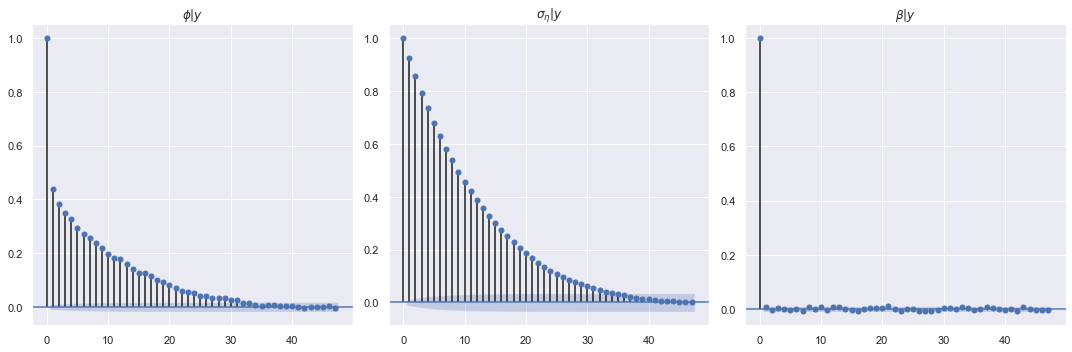

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_acf(phi2, ax = ax[0], title=r'$\phi | y$');
plot_acf(s2_n2**0.5, ax = ax[1], title=r'$\sigma_{\eta} | y$');
plot_acf(np.exp(mu2/2), ax = ax[2], title=r'$\beta | y$');

plt.tight_layout()
# plt.savefig('algo1_mistura_autocorr.png')

### Calculando algumas métricas

In [25]:
# média
print(r'- média de phi:',np.mean(trace_phi))
print(r'- média de sigma:',np.mean(trace_sigma2**0.5))
print(r'- média de beta:',np.mean(np.exp(trace_mu/2)))

- média de phi: 0.9807277730661138
- média de sigma: 0.16310334318517883
- média de beta: 1.5626427415901953


In [26]:
# desvio-padrão
print(r'- sd de phi:',np.std(trace_phi))
print(r'- sd de sigma:',np.std(trace_sigma2**0.5))
print(r'- sd de mu:',np.std(np.exp(trace_mu/2)))

- sd de phi: 0.007124485904497125
- sd de sigma: 0.023826105913717695
- sd de mu: 0.2517098107689578


In [27]:
# Erro-padrão numérico
print('MC S.E. phi:',stats.sem(trace_phi)[0])
print('MC S.E. sigma:',stats.sem(trace_sigma2**0.5)[0])
print('MC S.E. mu:',stats.sem(np.exp(trace_mu/2))[0])

MC S.E. phi: 1.4855580038341062e-05
MC S.E. sigma: 4.9680865138606484e-05
MC S.E. mu: 0.0005248512370490641


In [28]:
def ineficiencia(chain, Bm):
    acf = sm.tsa.stattools.acf(chain, nlags=Bm)
    inef = 0
    for i in range(Bm):
        z = i/Bm
        if 0<z and z<=0.5:
            k = 1-6*z**2 + 6*z**3
        elif 0.5<z and z <=1:
            k = 2*(1-z)**3
        else:
            k=0
        inef = inef + 2*Bm/(Bm-1)*k*acf[i]
    return 1+inef

In [29]:
print('Ineficiencia para phi:', ineficiencia(trace_phi[:,0], 2000))
print('Ineficiencia para sigma2:', ineficiencia(trace_sigma2[:,0]**0.5, 4000))
print('Ineficiencia para beta:', ineficiencia(np.exp(trace_mu/2)[:,0], 2000))

/home/franklin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Ineficiencia para phi: 51.518922697514235
Ineficiencia para sigma2: 107.32917853623957
Ineficiencia para beta: 1.5417418432694605


**Fim!**